In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = (img - np.min(img)) / (np.ptp(img))  # Normalize to [0, 1]
    return (rimg * 255).astype(np.uint8)

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)
        gt_img_3c[:, :, 0] = gt_img8
        gt_img_3c[:, :, 1] = gt_img8
        gt_img_3c[:, :, 2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    patches = []
    imgwidth, imgheight = im.shape[:2]
    for y in range(0, imgheight - h + 1, h):
        for x in range(0, imgwidth - w + 1, w):
            patch = im[x:x + w, y:y + h]
            patches.append(patch)
    return patches

In [3]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(20, len(files))  # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

n = 10  # Only use 10 images for training

Loading 20 images
satImage_001.png
Loading 20 images
satImage_001.png


Image size = 400,400


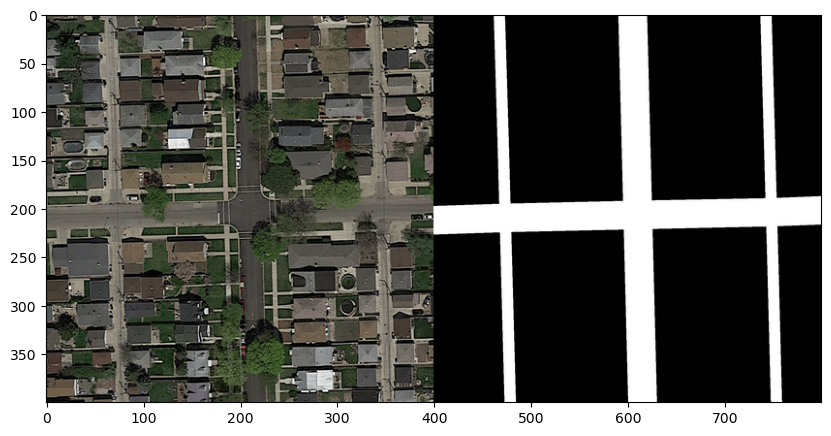

In [4]:
print("Image size = " + str(imgs[0].shape[0]) + "," + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap="Greys_r")

In [5]:
# Function to extract patches from a single image
def extract_patches(image, patch_size):
    """
    Extracts patches of size (patch_size x patch_size) from an image.

    Args:
        image (numpy.ndarray): The input image.
        patch_size (int): The size of the patches to extract.

    Returns:
        numpy.ndarray: A list of patches extracted from the image.
    """
    patches = []
    img_height, img_width = image.shape[:2]
    
    # Iterate over the image and extract patches
    for y in range(0, img_height - patch_size + 1, patch_size):
        for x in range(0, img_width - patch_size + 1, patch_size):
            patch = image[y:y + patch_size, x:x + patch_size]
            patches.append(patch)
    
    return np.array(patches)

# Extract patches for all images
patch_size = 16  # Each patch is 16x16 pixels

# Extract patches from training images and ground truth masks
img_patches = [extract_patches(img, patch_size) for img in imgs[:n]]
gt_patches = [extract_patches(gt, patch_size) for gt in gt_imgs[:n]]

# Flatten the list of patches for use in model training
img_patches = np.concatenate(img_patches, axis=0)
gt_patches = np.concatenate(gt_patches, axis=0)

In [6]:
# Extract 6-dimensional features: mean and variance for each RGB channel
def extract_features(img):
    """
    Extracts 6-dimensional features from an RGB image:
    - Mean and variance for each color channel (R, G, B).

    Args:
        img (numpy.ndarray): Input RGB image.

    Returns:
        numpy.ndarray: 6-dimensional feature vector.
    """
    mean_rgb = np.mean(img, axis=(0, 1))  # Mean for R, G, B
    var_rgb = np.var(img, axis=(0, 1))    # Variance for R, G, B
    return np.concatenate((mean_rgb, var_rgb))

# Extract 2-dimensional features: mean and variance for grayscale image
def extract_features_2d(img):
    """
    Extracts 2-dimensional features from a grayscale image:
    - Mean and variance of pixel intensities.

    Args:
        img (numpy.ndarray): Input grayscale image.

    Returns:
        numpy.ndarray: 2-dimensional feature vector.
    """
    mean_gray = np.mean(img)  # Mean intensity
    var_gray = np.var(img)    # Variance of intensity
    return np.array([mean_gray, var_gray])

# Extract features for patches of a given image
def extract_img_features(img, patch_size, feature_type='rgb'):
    """
    Extracts features for all patches in an image.

    Args:
        img (numpy.ndarray): Input image.
        patch_size (int): Size of each patch.
        feature_type (str): Type of features to extract ('rgb' or 'gray').

    Returns:
        numpy.ndarray: Array of features for all patches.
    """
    img_patches = extract_patches(img, patch_size)
    if feature_type == 'rgb':
        features = np.array([extract_features(patch) for patch in img_patches])
    elif feature_type == 'gray':
        gray_img = np.mean(img, axis=2)  # Convert to grayscale
        gray_patches = extract_patches(gray_img, patch_size)
        features = np.array([extract_features_2d(patch) for patch in gray_patches])
    else:
        raise ValueError("Invalid feature type. Choose 'rgb' or 'gray'.")
    return features

In [7]:
# Define the foreground threshold for class labeling
foreground_threshold = 0.25  # Percentage of road pixels required to classify a patch as road

def value_to_class(patch):
    """
    Assigns a class (0 or 1) to a patch based on the foreground threshold.
    Args:
        patch (numpy.ndarray): A ground truth patch.

    Returns:
        int: 1 if patch contains road, 0 otherwise.
    """
    road_ratio = np.mean(patch)  # Calculate the ratio of road pixels in the patch
    return 1 if road_ratio > foreground_threshold else 0

# Compute features and labels for all patches
# Extract RGB features (mean and variance for each channel)
X = np.asarray([extract_features_2d(img_patches[i]) for i in range(len(img_patches))])

# Assign labels based on ground truth patches
Y = np.asarray([value_to_class(gt_patches[i]) for i in range(len(gt_patches))])

# Print feature and label statistics
print(f"Computed {X.shape[0]} features")
print(f"Feature dimension: {X.shape[1]}")

# Count class distributions
class_counts = {0: np.sum(Y == 0), 1: np.sum(Y == 1)}
print(f"Class 0 (background): {class_counts[0]} samples")
print(f"Class 1 (road): {class_counts[1]} samples")

Computed 6250 features
Feature dimension: 2
Class 0 (background): 4422 samples
Class 1 (road): 1828 samples


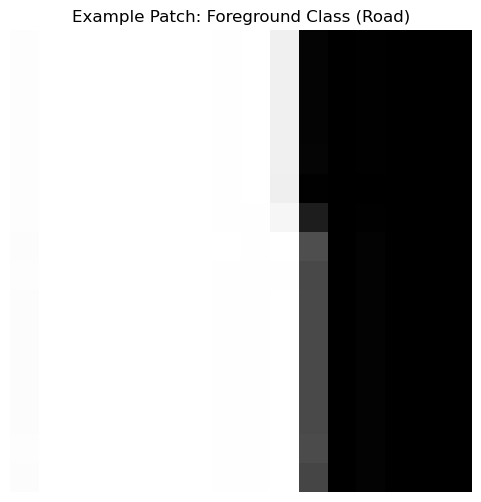

In [8]:
# Visualize one patch from the foreground class (road)
plt.figure(figsize=(6, 6))
plt.title("Example Patch: Foreground Class (Road)")
plt.imshow(gt_patches[np.where(Y == 1)[0][0]], cmap="Greys_r")
plt.axis("off")
plt.show()

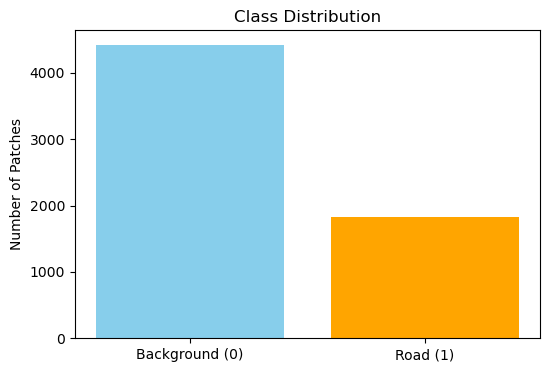

In [9]:
# Visualize class distribution
plt.figure(figsize=(6, 4))
plt.title("Class Distribution")
plt.bar(class_counts.keys(), class_counts.values(), color=["skyblue", "orange"])
plt.xticks([0, 1], ["Background (0)", "Road (1)"])
plt.ylabel("Number of Patches")
plt.show()

In [10]:
# 3D Feature Visualization (only applicable for RGB features with 6 dimensions)
if X.shape[1] == 6:  # RGB features
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=Y, cmap=plt.cm.Paired, s=20)
    ax.set_title("3D Feature Distribution (RGB Mean)")
    ax.set_xlabel("Red Mean")
    ax.set_ylabel("Green Mean")
    ax.set_zlabel("Blue Mean")
    legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
    plt.gca().add_artist(legend1)
    plt.show()

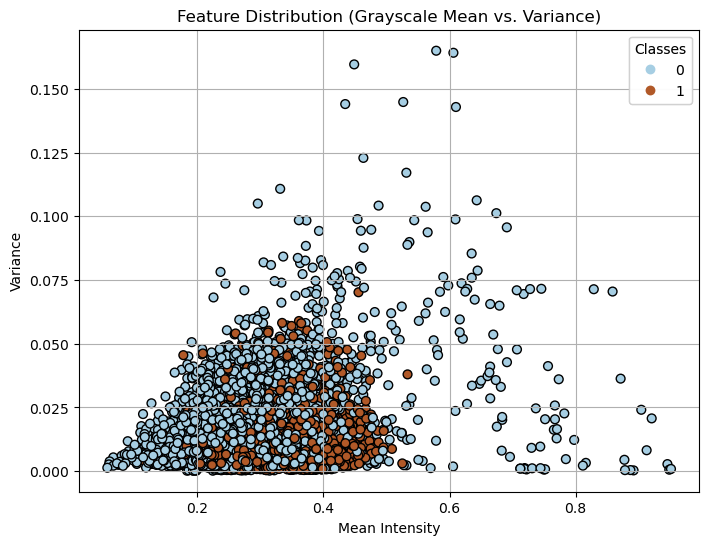

In [11]:
# 2D Feature Visualization (grayscale mean and variance)
if X.shape[1] == 2:  # Grayscale features
    plt.figure(figsize=(8, 6))
    plt.title("Feature Distribution (Grayscale Mean vs. Variance)")
    plt.xlabel("Mean Intensity")
    plt.ylabel("Variance")
    scatter = plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired, edgecolors="k", s=40)
    legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.gca().add_artist(legend1)
    plt.grid(True)
    plt.show()

In [12]:
# Train a logistic regression classifier
logreg = LogisticRegression(C=1e5, class_weight="balanced", max_iter=1000)
logreg.fit(X, Y)

LogisticRegression(C=100000.0, class_weight='balanced', max_iter=1000)

In [13]:
# Predict on the training set
Z = logreg.predict(X)

In [14]:
# Evaluate model performance
accuracy = accuracy_score(Y, Z)
precision = precision_score(Y, Z, pos_label=1)
recall = recall_score(Y, Z, pos_label=1)
f1 = f1_score(Y, Z, pos_label=1)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.6886
Precision: 0.4767
Recall: 0.6597
F1 Score: 0.5535


In [15]:
# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Z)[0]
Yn = np.nonzero(Y)[0]

In [16]:
TPR = len(list(set(Yn) & set(Zn))) / float(len(Z))
print("True positive rate = " + str(TPR))

True positive rate = 0.19296


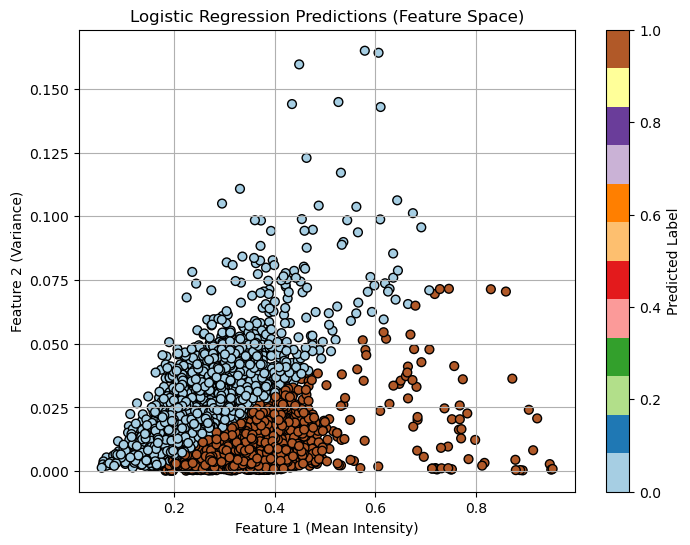

In [17]:
# Visualize features with predictions as colors
plt.figure(figsize=(8, 6))
plt.title("Logistic Regression Predictions (Feature Space)")
plt.xlabel("Feature 1 (Mean Intensity)")
plt.ylabel("Feature 2 (Variance)")
plt.scatter(X[:, 0], X[:, 1], c=Z, cmap=plt.cm.Paired, edgecolors="k", s=40)
plt.colorbar(label="Predicted Label")
plt.grid(True)
plt.show()

In [18]:
# Convert array of labels to an image
def label_to_img(imgwidth, imgheight, patch_width, patch_height, labels):
    """
    Convert a flat array of labels into an image of patches.

    Args:
        imgwidth (int): Width of the original image.
        imgheight (int): Height of the original image.
        patch_width (int): Width of each patch.
        patch_height (int): Height of each patch.
        labels (numpy.ndarray): Flat array of patch labels.

    Returns:
        numpy.ndarray: Reconstructed image from patch labels.
    """
    im = np.zeros((imgwidth, imgheight))
    idx = 0
    for y in range(0, imgheight, patch_height):
        for x in range(0, imgwidth, patch_width):
            im[x : x + patch_width, y : y + patch_height] = labels[idx]
            idx += 1
    return im

In [19]:
# Create an overlay image with predictions
def make_img_overlay(img, predicted_img):
    """
    Create an overlay of predictions on the original image.

    Args:
        img (numpy.ndarray): Original image.
        predicted_img (numpy.ndarray): Binary predicted image.

    Returns:
        PIL.Image: Image with overlay.
    """
    w, h = img.shape[:2]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:, :, 0] = (predicted_img * 255).astype(np.uint8)

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, "RGB").convert("RGBA")
    overlay = Image.fromarray(color_mask, "RGB").convert("RGBA")
    return Image.blend(background, overlay, alpha=0.4)

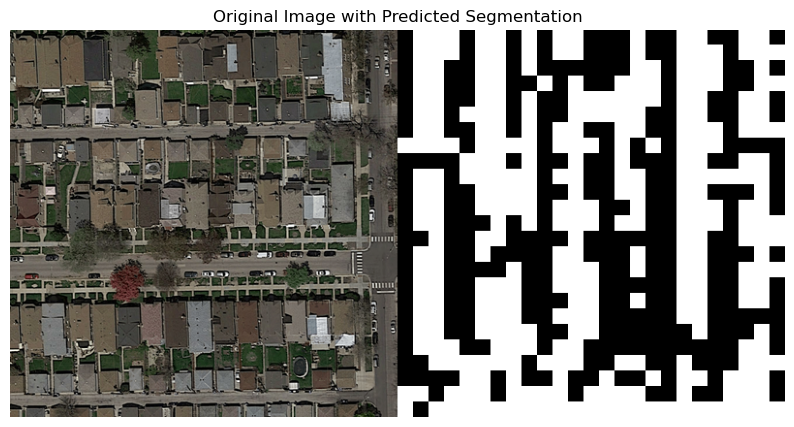

In [20]:
# Run prediction on a single image
img_idx = 12  # Index of the image to predict
img = load_image(image_dir + files[img_idx])  # Load the image
Xi = extract_img_features(img, patch_size=16, feature_type="gray")  # Extract features
Zi = logreg.predict(Xi)

# Convert predictions to an image
w, h = gt_imgs[img_idx].shape[:2]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)

# Display original image with predictions
plt.figure(figsize=(10, 10))
cimg = concatenate_images(imgs[img_idx], predicted_im)
plt.title("Original Image with Predicted Segmentation")
plt.imshow(cimg, cmap="Greys_r")
plt.axis("off")
plt.show()

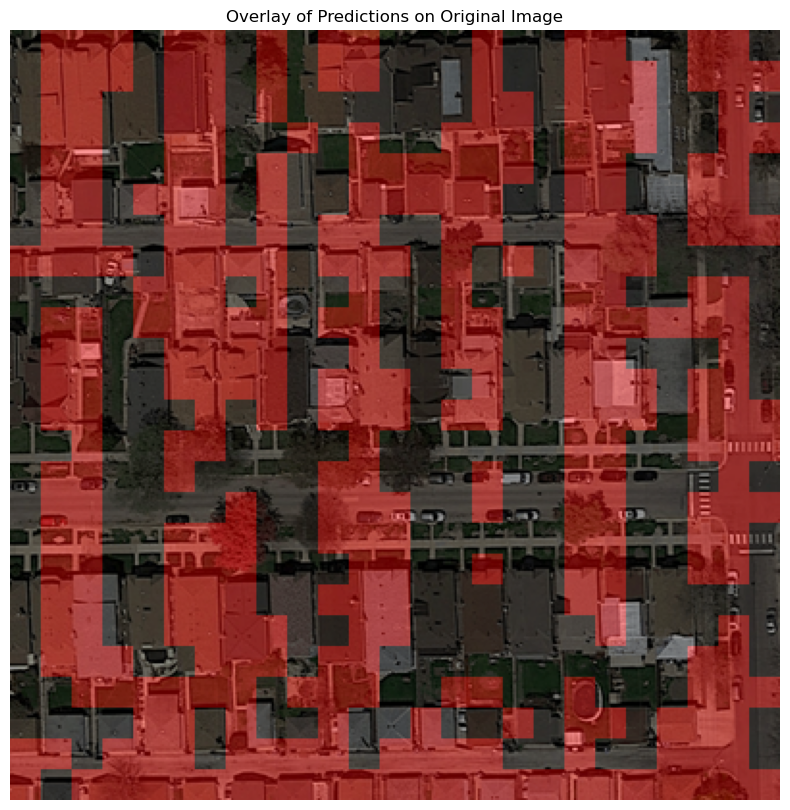

In [21]:
# Display overlayed predictions
new_img = make_img_overlay(imgs[img_idx], predicted_im)
plt.figure(figsize=(10, 10))
plt.title("Overlay of Predictions on Original Image")
plt.imshow(new_img)
plt.axis("off")
plt.show()